## Steps
1. In the previous notebook we did the below pre-processing steps
  - Uncompress the zip file
  - Read all the images mentioned in 'consolidation_train_gt.csv'
  - Changed the size of all images to 400x400
  - Saved the images and labels into a numpy file
  - Saved the file in Google Drive
The above process reduced the file size from 16GB to 7GB. The same file will be used in this notebook

In [2]:
# Connecting to google drive and defining the file path
from google.colab import drive
drive.mount('/content/drive')
file_path='/content/drive/MyDrive/Colab Notebooks/Covid Chest Xray'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Importing all the libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from keras.applications.vgg16 import VGG16
from keras.models import Model

# Loading training data
train=np.load(file_path+'/train.npz')
x_train=train['data']
Y_train=train['label']
y_train=np.zeros((len(Y_train),2))
for i,value in enumerate(Y_train):
  y_train[i][value]=1
del train

# Loading testing data
test=np.load(file_path+'/test.npz')
x_test=test['data']
Y_test=test['label']
y_test=np.zeros((len(Y_test),2))
for i,value in enumerate(Y_test):
  y_test[i][value]=1
del test

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


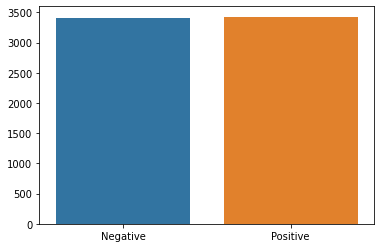

In [5]:
# Plot of data distribution
import seaborn as sns
sns.barplot(['Negative','Positive'],[len(Y_train[Y_train==0]),len(Y_train[Y_train==1])])

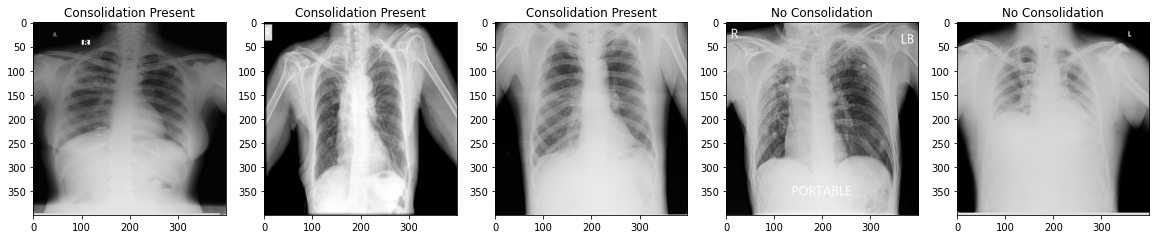

In [6]:
dict={1:'Consolidation Present',0:'No Consolidation'}
plt.figure(figsize=(20,5))
for i in range(5):
  plt.subplot(1,5,i+1)
  plt.imshow(x_train[i])
  plt.title(dict[Y_train[i]])

In [7]:
# Loading the VGG NET model for transfer learning. 
#Since the XRAY images are very different from the Imagenet dataset, we will only be using the first few layers.

from keras import Input
new_input = Input(shape=(400, 400, 3)) 
base_model=VGG16(weights=(file_path+'/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'),input_tensor=new_input,include_top=False, pooling='avg')

In [8]:
# Since X-Ray images and ImageNet images are very different we are only taking the first half of the model layers
model=Model(inputs=base_model.layers[0].input,outputs=base_model.get_layer('block3_pool').output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400, 400, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 400, 400, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 400, 400, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 200, 200, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 200, 200, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 200, 200, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 100, 100, 128)     0     

In [9]:
# Creating a top layer

from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D,Dense,Flatten
top_layer=Sequential()
top_layer.add(Conv2D(512,(3,3),input_shape=(50,50,256),padding='same',activation='relu'))
top_layer.add(Conv2D(512,(3,3),padding='same',activation='relu'))
top_layer.add(MaxPooling2D((2,2)))
top_layer.add(Conv2D(1024,(3,3),padding='same',activation='relu'))
top_layer.add(MaxPooling2D((2,2)))
top_layer.add(Conv2D(1024,(3,3),padding='same',activation='relu'))
top_layer.add(MaxPooling2D((2,2)))

top_layer.add(Flatten())
top_layer.add(Dense(256,activation='relu'))
top_layer.add(Dense(64,activation='relu'))
top_layer.add(Dense(8,activation='relu'))
top_layer.add(Dense(2,activation='softmax'))

top_layer.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [10]:

top_layer.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 512)       1180160   
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 512)       2359808   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 512)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 1024)      4719616   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 1024)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 1024)      9

# For Binary predictions

In [11]:
# from tqdm import tqdm
# vgg_embedding=[]
# for image in tqdm(x_train):
#   im=np.expand_dims(image,axis=0)
#   vgg_embedding.append(model.predict(im))

In [12]:
# Getting embeddings from the existing model for the train images
from tqdm import tqdm

for train in np.array_split(x_train,10):
  embedding=[]
  for image in train:
    im=np.expand_dims(image,axis=0)
    embedding.append(model.predict(im))
  embedding=np.array(embedding)
  embedding=np.squeeze(embedding)
  target=np.array(y_train[0:len(embedding)])
  y_train=y_train[len(embedding):]
  top_layer.fit(embedding,target)

22/22 [==============================] - 9s 417ms/step - loss: 0.6931 - accuracy: 0.5242
